In [1]:
import sys 
sys.path.append("/cellar/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
sys.path.insert(1, '/cellar/users/mpagadal/Data/scripts')
import json

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import product
import seaborn as sns
import networkx as nx
from ndex2.nice_cx_network import NiceCXNetwork 
import ndex2.client as nc
import ndex2

In [3]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
from get_brian_rna import *

In [5]:
from upsetplot import generate_counts
from upsetplot import plot
from matplotlib import pyplot

## Collect phenotype IDs

Our goal was to collect central phenotypes that shape the tumor immune microenvironment. These phenotypes include measures of immune states, immune infiltration and gene expression collected from a variety of sources, including gene sets, literature, and results of tool calculations

In [6]:
def filter_zeros(df,threshold):
    '''
    inputs:
    df: dataframe of rna values
    threshold: % of zero values by which to exclude phenotypes
    
    output:
    dataframe with rna values < threshold of zero values
    '''
    
    keep=[]
    remove=[]
    
    for x in df.columns:
        if len(df[df[x]==0])>threshold*len(df):
            remove.append(x)
        else:
            keep.append(x)
    
    print("{} phenotypes with > {} zeroes were removed".format(len(remove),threshold))
    return(df[keep])
        

In [7]:
antigen_present=pd.read_csv("../downloaded_phenos/antigen_present_geneset.txt",skiprows=[1])
antigen_present_list=antigen_present["GO_ANTIGEN_PROCESSING_AND_PRESENTATION"].tolist()
antigen_present_list.append("MARCH1")

In [8]:
im_landscape=pd.read_csv("../downloaded_phenos/im-landscape-markers.txt",header=None)
im_landscape_list=im_landscape[0].tolist()

In [9]:
danaher=pd.read_csv("../downloaded_phenos/danaher_markers.csv")
danaher_list=danaher["Gene"].tolist()

In [10]:
im_checkpoint=pd.read_csv("../downloaded_phenos/immune-checkpoint.csv")
im_checkpoint_list=im_checkpoint["HGNC Symbol"].tolist()
im_checkpoint_list=[x for x in im_checkpoint_list if str(x) != "nan"]

In [11]:
landscape=pd.read_csv("../downloaded_phenos/pheno-immune-landscape-comp",delimiter="\t")
landscape_comps=landscape.columns[2:]

In [12]:
ifng=pd.read_csv("../downloaded_phenos/ifng-markers.txt",header=None)
ifng_list=ifng[0].tolist()

In [13]:
tgfbeta=pd.read_csv("../downloaded_phenos/tgf-beta-markers.txt",header=None)
tgfbeta_list=tgfbeta[0].tolist()

In [14]:
cibersortx=pd.read_csv("/cellar/users/mpagadal/Data/cibersort/cibersortx_compiled_allsig.tsv",delimiter="\t")
cibersortx_list=[x.replace(" ",".") for x in cibersortx.columns[1:]]

In [15]:
print(len(antigen_present_list))
print(len(im_landscape_list))
print(len(danaher_list))
print(len(im_checkpoint_list))
print(len(landscape_comps))
print(len(ifng_list))
print(len(tgfbeta_list))
print(len(cibersortx_list))


228
436
60
78
6
6
19
61


### Create phenotype dictionary

In [16]:
pheno_dict={}

for x in antigen_present_list:
    x=x.replace("-",".")
    pheno_dict[x]="antigen present"
for x in im_landscape_list:
    x=x.replace("-",".")
    pheno_dict[x]="immunomodulators"
for x in danaher_list:
    x=x.replace("-",".")
    pheno_dict[x]="cell type"
for x in im_checkpoint_list:
    x=x.replace("-",".")
    pheno_dict[x]="immune checkpoint"
for x in landscape_comps:
    x=x.replace("-",".")
    pheno_dict[x]="landscape components"
for x in ifng_list:
    x=x.replace("-",".")
    pheno_dict[x]="IFNG"    
for x in tgfbeta_list:
    x=x.replace("-",".")
    pheno_dict[x]="TGFbeta"
for x in cibersortx_list:
    x=x.replace("-",".")
    pheno_dict[x]="immune infiltration"

In [17]:
for x in pheno_dict.keys():
    if "HLA" in x:
        pheno_dict[x]="antigen present"

In [18]:
print(len(pheno_dict))

833


In [19]:
import json
with open('pheno_dictionary.json', 'w') as json_file:
    json.dump(pheno_dict, json_file)

In [20]:
with open('pheno_dictionary.json', 'r') as f:
    pheno_dict = json.load(f)

In [21]:
pheno_dict["BRCA2"]

'immunomodulators'

## Make phenotype file for PLINK

### Collect RNA phenotypes from TPM data

In [22]:
def brian_tpm_filter(lst):
    #load brian's rna dataframe
    colnames = np.loadtxt('/cellar/users/btsui/Data/nrnb01_nobackup/Data/SRA/MATRIX/DATA/hgGRC38/TCGAmatrix.realign.gene.hgnc.columns.txt', dtype=str)
    rownames = np.loadtxt('/cellar/users/btsui/Data/nrnb01_nobackup/Data/SRA/MATRIX/DATA/hgGRC38/TCGAmatrix.realign.gene.hgnc.index.txt', dtype=str)
    tcga_df = pd.DataFrame(np.load('/cellar/users/btsui/Data/nrnb01_nobackup/Data/SRA/MATRIX/DATA/hgGRC38/TCGAmatrix.realign.gene.hgnc.npy'), index=rownames, columns=colnames)

    #get legacy mapping data
    legacy_df = pd.read_csv('/cellar/users/andreabc/Data/GDC_barcodes/LEGACY_uuid_barcode_map.txt', 
                        sep='\t', index_col='submitter_uuid')
    legacy_df = legacy_df.reset_index()
    legacy_df = legacy_df[legacy_df.submitter_uuid.notnull()] #get rid of null submitter uuid
    
    #filter dataframe for genes in list
    filt = tcga_df.loc[tcga_df.index.isin(lst),:]
    filt =  filt.T
    
    #map ids to TCGA barcode
    dic = dict(zip(legacy_df.submitter_uuid, legacy_df.sample_barcode))
    filt.index=filt.index.map(dic)
    filt=filt[filt.index.notnull()]

    return(filt)

In [23]:
all_pheno=antigen_present_list+im_landscape_list+danaher_list+im_checkpoint_list+ifng_list+tgfbeta_list
rna=brian_tpm_filter(all_pheno)

In [24]:
rna["code"]=rna.index.str.split("-").str[-1]
rna["barcode"]=rna.index.str[0:12]

In [25]:
canc = pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
rna["cancer"]=rna["barcode"].map(mp)

In [34]:
rna_normal=rna[rna["code"].str.startswith("1")]

In [35]:
rna_normal["code"].value_counts()

11A    714
11B     17
11C      1
Name: code, dtype: int64

In [36]:
#convert index to short barcodes
del rna_normal["code"]
del rna_normal["cancer"]
rna_normal.index=rna_normal["barcode"]
del rna_normal["barcode"]

In [37]:
#take mean for individuals with multiple samples
rna=rna_normal
rna=rna.groupby(rna.index).mean()

In [38]:
#filter out phenotypes with > 10% zero values
rna=filter_zeros(rna,0.1)

33 phenotypes with > 0.1 zeroes were removed


In [39]:
print(rna.shape)

(731, 731)


In [40]:
rna=rna.reset_index().rename(columns={"barcode":"FID"}).set_index("FID")

### Filter for only genotyped patients

In [45]:
#get genotyped patients
fam=pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/imputation/michigan-imputation/HRC/european.final.noimmunecancers.clean.fam",header=None,sep=" ")[0].tolist()

In [46]:
tcga_df=rna[rna.index.isin(fam)]

In [47]:
tcga_df=tcga_df.reset_index()

In [48]:
tcga_df=tcga_df.rename(columns={"index":"FID"})

In [49]:
print(tcga_df.shape)
tcga_df.head()

(611, 732)


,FID,FGR,SEMA3F,DBNDD1,SLC25A5,CREBBP,WDR54,ITGA3,AP2B1,CX3CL1,...,DYNLL2,SEC22B,IKBKG,SPIB,CCL5,B2M,IFI27,LILRB2,PDCD1,LAIR1
0,TCGA-22-4593,52.741341,15.020543,4.582214,429.171570,9.122368,11.910508,160.098160,63.754631,27.899931,...,22.742100,16.280651,18.326183,1.704765,13.366350,1116.949951,9.388349,11.580532,0.684606,72.930031
1,TCGA-22-4609,33.633781,16.718197,3.968237,213.296768,24.401106,10.205466,140.817017,61.474487,171.599884,...,25.734800,16.778450,16.744671,1.920931,11.640704,1341.969971,31.000149,5.172295,1.269880,2.152551
2,TCGA-22-5471,44.874718,9.870248,7.872812,273.032104,16.605223,35.272629,170.285492,63.103294,58.130230,...,21.632900,13.636040,20.903175,0.799475,4.631590,882.776001,26.662445,3.884185,0.263936,37.160728
3,TCGA-22-5472,44.056370,20.890659,6.082714,254.809647,21.647938,21.475487,138.442764,89.757324,54.630062,...,28.040199,18.620789,17.859312,1.321082,7.909300,1024.579956,16.930290,11.225962,1.485900,26.772093
4,TCGA-22-5478,55.746078,20.647762,5.458734,235.072891,24.435022,13.300381,180.409561,76.275681,100.485710,...,27.382500,15.759120,19.987007,3.526640,14.037420,1105.920044,33.454338,10.710560,0.734698,29.996195


## Submit cancer-specific phenos for rank normalization

In [50]:
canc = pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
#total['cancer'] = total["FID"].map(mp)
tcga_df["cancer"]=tcga_df["FID"].map(mp)

In [51]:
for x in tcga_df["cancer"].unique():
    try:
        tumor=tcga_df[tcga_df["cancer"]==x]
        del tumor["cancer"]
        tumor.to_csv("/cellar/users/mpagadal/Data/projects/germline-immune/processed_phenos/brian-tpm/normal/pheno_"+x+".unnorm.csv",index=None,sep="\t")
    except:
        pass
    
    

In [52]:
compiled=pd.DataFrame()
for x in tcga_df["cancer"].unique().tolist():
    try:
        df=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/processed_phenos/brian-tpm/normal/pheno_"+x+".rank.csv",delimiter="\t")
        df["cancer"]=x
        compiled=compiled.append(df)
    except:
        pass

### Confirm rank norm by cancer

Text(0.5, 1.0, 'FGR')

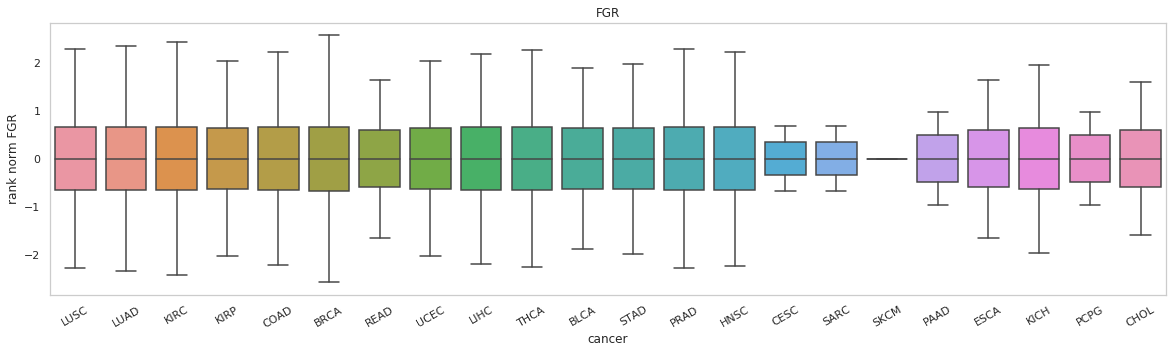

In [53]:
x="FGR"
#plot rna expression by cancer type
sns.set(style="whitegrid", font_scale = 1)
plt.figure(figsize=(20,5))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.boxplot(x="cancer", y=x, data=compiled)
ax.set(xlabel="cancer", ylabel='rank norm FGR')
plt.xticks(rotation=30)
plt.title(x)

In [54]:
del compiled["cancer"]
compiled["IID"]=compiled["FID"]
cols=["FID","IID"]+compiled.columns.tolist()[1:-1]
compiled=compiled[cols]
compiled.columns=[x.replace("-",".") for x in compiled.columns]
compiled=compiled.fillna(-9)

In [55]:
compiled.to_csv("/cellar/users/mpagadal/Data/projects/germline-immune/processed_phenos/brian-tpm/normal/pheno_all_zcancer",index=None,sep="\t")